# Atividade: Dense Neural Network Breast Cancer
**INSTITUTO FEDERAL DE MINAS GERIAS**
*Departamento de Engenharia e Computação*

**Professor:** Ciniro Nametala

**Aluno:** Euler Gomes

Neste trabalho, vamos utilizar o dataset Breast Cancer Wisconsin (Diagnostic) disponível no repositório de datasets da UCI. Este é um conjunto de dados multivariado com atributos numéricos de ponto-flutuante usado para classificação do tipo de cancêr de mama de um paciente com MALIGNO ou BENIGNO. O dataset mostra resultados de exames de 699 pacientes coletados em

1. ID do paciente
2. Espessura (1-10)
3. Uniformidade de tamanho da célula (1-10)
4. Uniformidade de forma da célula (1-10)
5. Adesão marginal (1-10)
6. Tamanho único epitelial da célula (1-10)
7. Quantidade de núcleos nus (1-10)
8. Cromatina (1-10)
9. Quantidade de núcleos normais (1-10)
10. Mitoses (1-10)
[SAIDA] 11. Classificação (2 para indicar BENIGNO, 4 para inicar MALIGNO)

O dataset contém 458 amostras com:
- 65.5% de casos BENIGNOS
- 34.5% de casos MALIGNOS

In [24]:
#funcao para deixar o Jupyter com celular preenchendo a tela toda
from IPython.display import display, HTML
from babel.util import missing

display(HTML("<style>.container {widht: 100% !important;}</style>"))

In [25]:
#importacao de bibliotecas
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#utilitario de GPU
from numba import cuda

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy

#bibliotecas para plotar graficos do keras
import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model, model_to_dot

tensorflow.keras.utils.pydot = pyd


In [26]:
#checagem de gpu
import tensorflow as tf
import keras

print('TensorFlow:', tf.__version__)
print('Keras:', keras.__version__)
print('GPU disponivel:', len(tf.config.list_physical_devices('GPU')))

TensorFlow: 2.20.0
Keras: 3.10.0
GPU disponivel: 1


In [27]:
#rotina para exportacao da lista de pacotes
def exportaRequirements():
    try:
        resultado = subprocess.run([sys.executable, "-m", "pip", "freeze"],
                                   capture_output=True,
                                   text=True,
                                   check=True)
        with open('requirements.txt', 'w') as f:
            f.write(resultado.stdout)
        print('Arquivo requirements.txt gerado com sucesso')
    except subprocess.CalledProcessError as e:
        print('Erro ao gerar arquivo requirements.txt:', e)


exportaRequirements()

Arquivo requirements.txt gerado com sucesso


## 2. Importação do dataset

In [28]:
#2 benigno 4 maligno
col_names = ['ID', 'espessura', 'tam_celula', 'forma_celula', 'adesao', 'tam_epitelial', 'nucleos_nus', 'cromatina',
             'nucleos_normais', 'mitoses', 'diagnostico']
#importacao do dataset
data = pd.read_csv('dataset/dataset_breastcancer.csv', header=None, names=col_names)
#remove a coluna ID do dataset
data = data.drop(columns=['ID'], axis=1)

#substitui interrogação por NaN
data = data.replace('?', np.nan)

#converte tudo para numero
data = data.astype(float)

#converte o codigo do diagnostico para 0 e 1
data = data.assign(diagnostico=data['diagnostico'].replace({2: 0, 4: 1}))

#nomeia as estradas e saidas
x_names = data.columns[:-1].tolist()
y_names = data.columns[-1:].tolist()

data.head()


,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0


## 3. Configuração do Experimento

In [29]:
#realizar interpolacao de dados
interp_exec = True

#realizar deteccao e substituicao de outliers
outliers_exec = True

#realizar normalizacao de dados
normalization_exec = True

#realizar escalonamento de dados
scale_exec = True

#exportar os datasets tratados
export_frames = True

#gerar um novo modelo ou usar um pronto
new_model = True

## 4. Análise de Dados

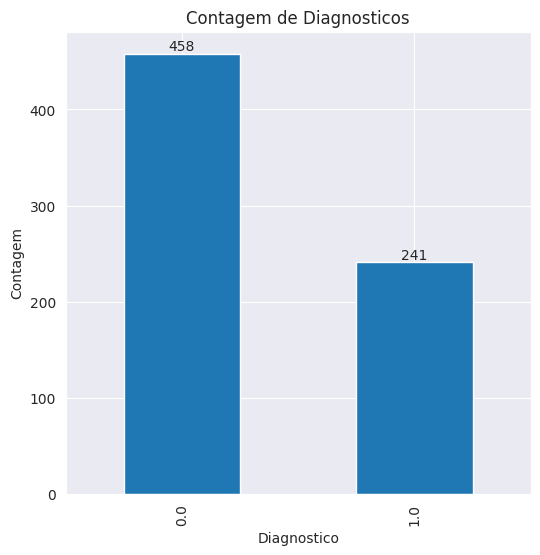

In [30]:
#contagem de diagnosticos
diag_counts = data['diagnostico'].value_counts()

#plota grafico de barra
plt.figure(figsize=(6, 6))
diag_counts.plot(kind="bar")
plt.xlabel("Diagnostico")
plt.ylabel('Contagem')
plt.title('Contagem de Diagnosticos')

#adiciona os rotulos
for i, count in enumerate(diag_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

## 4.1. Sumarização estatística

In [31]:
def sumarizacao(data):
    stats = []

    for column in x_names:
        values = data[column]

        maximum = round(values.max(), 2)
        minimum = round(values.min(), 2)
        mean = round(values.mean(), 2)
        median = round(values.median(), 2)
        std = round(values.std(), 2)

        stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Coluna', 'Máximo', 'Minimo', 'Média', 'Mediana', 'Desvio Padrão']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)


sumarizacao(data)

| Coluna          |   Máximo |   Minimo |   Média |   Mediana |   Desvio Padrão |
|:----------------|---------:|---------:|--------:|----------:|----------------:|
| espessura       |       10 |        1 |    4.42 |         4 |            2.82 |
| tam_celula      |       10 |        1 |    3.13 |         1 |            3.05 |
| forma_celula    |       10 |        1 |    3.21 |         1 |            2.97 |
| adesao          |       10 |        1 |    2.81 |         1 |            2.86 |
| tam_epitelial   |       10 |        1 |    3.22 |         2 |            2.21 |
| nucleos_nus     |       10 |        1 |    3.54 |         1 |            3.64 |
| cromatina       |       10 |        1 |    3.44 |         3 |            2.44 |
| nucleos_normais |       10 |        1 |    2.87 |         1 |            3.05 |
| mitoses         |       10 |        1 |    1.59 |         1 |            1.72 |


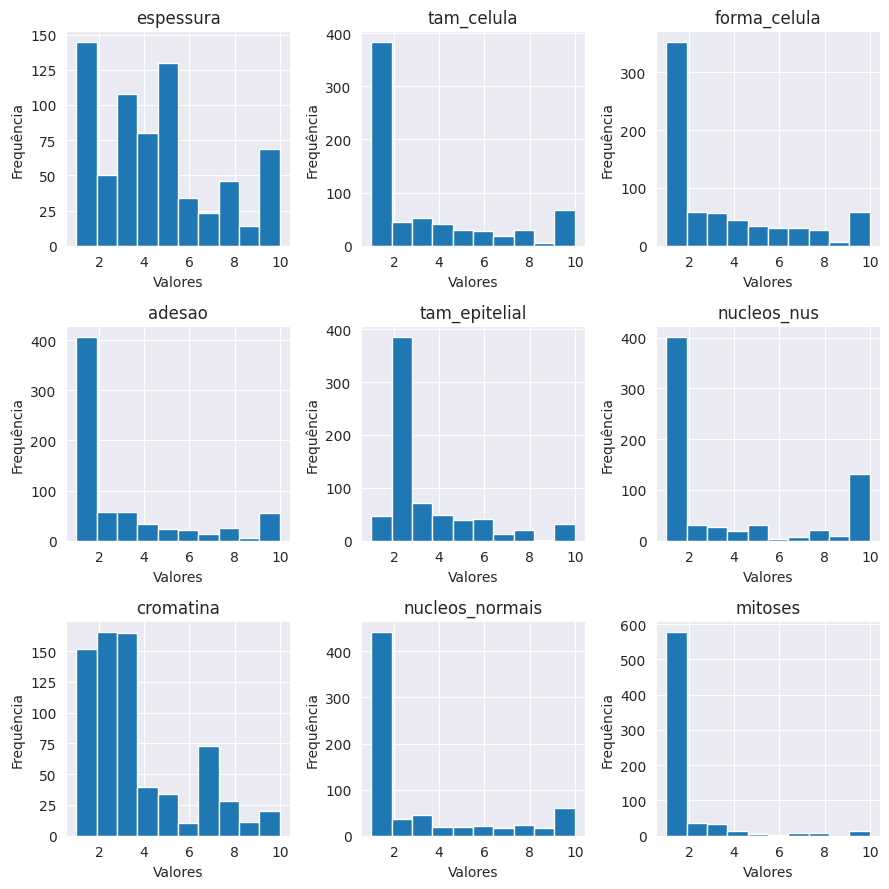

In [32]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9), tight_layout=True)

for i, column in enumerate(x_names):
    row = i // 3  #linha atual
    col = i % 3  #coluna atual

    axs[row, col].hist(data[column], bins=10)
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Frequência')


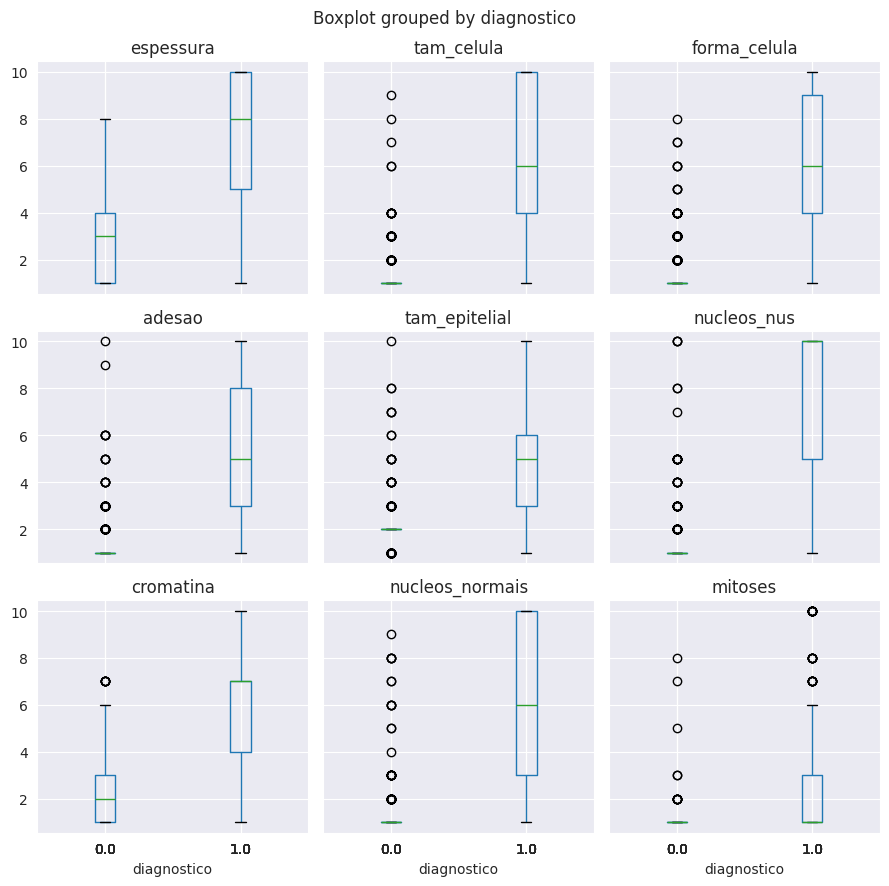

In [33]:
data.boxplot(column=x_names, by='diagnostico', figsize=(9, 9))
plt.tight_layout()
plt.show()

## 4.2. Detecção de dados faltantes e interpolação

In [34]:
#deteccao de dados faltantes
missing_counts = data.isnull().sum()
print("Total de dados faltantes por atributo:")
print(missing_counts)

Total de dados faltantes por atributo:
espessura           0
tam_celula          0
forma_celula        0
adesao              0
tam_epitelial       0
nucleos_nus        16
cromatina           0
nucleos_normais     0
mitoses             0
diagnostico         0
dtype: int64


In [35]:
#intepola os dados faltantes
def interpolacao(data):
    if data.isnull().values.any():
        points_inds_danger = [0, 1, len(data) - 2, len(data) - 1]
        for col_name in x_names:
            for ind_danger in points_inds_danger:
                if np.isnan(data[col_name].iloc[ind_danger].astype(float)):
                    data[col_name].iloc[ind_danger] = data[col_name].mean()

            data[col_name] = data[col_name].interpolate(method='nearest').copy()
    return data

In [36]:
if interp_exec:
    data = interpolacao(data)

#deteccao de dados faltantes
missing_counts = data.isnull().sum()
print("Total de dados faltantes por atributo:")
print(missing_counts)

Total de dados faltantes por atributo:
espessura          0
tam_celula         0
forma_celula       0
adesao             0
tam_epitelial      0
nucleos_nus        0
cromatina          0
nucleos_normais    0
mitoses            0
diagnostico        0
dtype: int64


## 4.3. Detecção e substituição de outliers

In [37]:
def getQuantiles(x, margin=1.5, low=0.1, high=0.9):
    q1 = x.quantile(low)
    q3 = x.quantile(high)
    iqr = q3 - q1
    fence_low = q1 - (margin * iqr)
    fence_high = q3 + (margin * iqr)

    return [fence_low, fence_high]


def replaceOutliers(serie, m):
    x = serie.copy()

    fences = getQuantiles(x, margin=m)
    bad_inds = x.loc[(x < fences[0]) | (x > fences[1])].index
    x[bad_inds] = np.nan

    outliers_ind_danger = [0, 1, len(serie) - 2, len(serie) - 1]
    for ind_danger in outliers_ind_danger:
        if np.isnan(x.iloc[ind_danger]):
            x[ind_danger] = (fences[0] + fences[1]) / 2
    if x.isnull().values.any():
        x = x.interpolate(method='nearest').copy()

    return x

In [38]:
if outliers_exec:
    for col in x_names:
        data[col] = replaceOutliers(data[col], m=0)

## 4.4. Aplicando a normalização (estabilização de variância)

In [39]:
def normalization(data, method):
    if method == 'asinh':
        return np.arcsinh(data)
    elif method == 'log':
        return np.log(data)
    else:
        return (data - np.mean(data)) / np.std(data)

In [40]:
if normalization_exec:
    for col in x_names:
        data[col] = normalization(data[col], 'mean')

In [41]:
data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,0.481973,-0.653930,-0.706788,-0.582619,-0.620341,-0.696275,0.026555,-0.544156,-0.331584,0.0
1,0.481973,0.728420,0.683582,1.497845,0.953592,1.781250,0.026555,-0.089717,-0.331584,0.0
2,-0.386324,-0.653930,-0.706788,-0.582619,-0.620341,-0.420994,0.026555,-0.544156,-0.331584,0.0
3,0.916122,2.571552,2.537408,-0.582619,0.166625,0.129567,0.026555,2.182474,-0.331584,0.0
4,0.047825,-0.653930,-0.706788,0.457613,-0.620341,-0.696275,0.026555,-0.544156,-0.331584,0.0
...,...,...,...,...,...,...,...,...,...,...
694,-0.386324,-0.653930,-0.706788,-0.582619,0.166625,-0.420994,-1.034124,-0.544156,-0.331584,0.0
695,-0.820473,-0.653930,-0.706788,-0.582619,-0.620341,-0.696275,-1.034124,-0.544156,-0.331584,0.0
696,0.481973,-0.653930,-0.706788,0.457613,-0.620341,-0.145714,-1.034124,-0.544156,1.683871,1.0
697,0.047825,2.571552,1.610495,0.977729,0.166625,0.129567,0.556894,1.728036,-0.331584,1.0


## 4.5. Aplicando escalonamento dos dados

In [44]:
#funcao que cria uma regua com valores minimos e maximos para se usar no escalonamento
def create_support_col(minvalue, maxvalue, sizecol):
  minvalues = [minvalue] * round(sizecol/2)
  maxvalues = [maxvalue] * (sizecol - round(sizecol/2))
  return(*minvalues, *maxvalues)


def minMaxIndividual(df, col, minvalue, maxvalue, rgint):
  serie = df[col].copy()

  #cria uma regra com um valor minimo e maximo previamente determinado
  serie['support'] = create_support_col(minvalue, maxvalue, len(serie))

  #escalona considerando o minimo e o maximo especificado
  tmp = serie.to_numpy().reshape(-1,1)

  #cria o objeto de escalonamento
  minmaxscaler = preprocessing.MinMaxScaler(feature_range = rgint).fit(tmp)

  #cria os dados escalonados
  scaled = minmaxscaler.transform(tmp).reshape(serie.shape[0], serie.shape[1])

  #remove a coluna de suporte e atualiza as colunas escalonadas no dataset
  df[col] = scaled[:,0:(scaled.shape[1] -1)]

  return df

In [45]:
#aplicando o escalonamento
scale_range = (0,1)
if scale_exec:
    for col in x_names:
        data = minMaxIndividual(data, [col], np.min(data[col]), np.max(data[col]), scale_range)

In [46]:
data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,0.500,0.000,0.000000,0.000000,0.00,0.000000,0.333333,0.000,0.0,0.0
1,0.500,0.375,0.428571,0.571429,0.50,1.000000,0.333333,0.125,0.0,0.0
2,0.250,0.000,0.000000,0.000000,0.00,0.111111,0.333333,0.000,0.0,0.0
3,0.625,0.875,1.000000,0.000000,0.25,0.333333,0.333333,0.750,0.0,0.0
4,0.375,0.000,0.000000,0.285714,0.00,0.000000,0.333333,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,0.250,0.000,0.000000,0.000000,0.25,0.111111,0.000000,0.000,0.0,0.0
695,0.125,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.0,0.0
696,0.500,0.000,0.000000,0.285714,0.00,0.222222,0.000000,0.000,0.5,1.0
697,0.375,0.875,0.714286,0.428571,0.25,0.333333,0.500000,0.625,0.0,1.0
